# Session 11: Data Processing

In [1]:
import logging
import os
from datetime import datetime

import matplotlib.pyplot as plt
from pdgraster import RasterTiler

# For parallel processing
import parsl
import parsl
from parsl import python_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

# set up plotting in notebook
plt.style.use('seaborn-notebook')
font_size = 4
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['legend.fontsize'] = font_size
plt.rcParams['figure.titlesize'] = font_size
plt.rcParams['figure.dpi'] = 200

/home/sjclark/miniconda3/envs/scale_comp/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## The `RasterTiler` class

The purpose of the RasterTiler class is to read in tiled vector data (the out put of staging), and create raster data from each vector tile.

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-raster/develop/docs/images/raster_tldr.png)

The `RasterTiler` takes the same config as the `TileStager` class, but we add a few more options for rasterization.

In [2]:
# Here are the options that we set for the TileStager
iwp_config = {
    # The directory and file type of the input vector data the we want to stage
    'dir_input': 'example-data',
    'ext_input': '.gpkg',
    # The path to the directory where we want the output tiles to be saved
    # (this will be created if it doesn't exist)
    'dir_staged': 'staged',
    # Set simplify_tolerance to None to disable polygon simplification (not
    # needed)
    'simplify_tolerance': None
}

# Here are the extra options we will use for rasterization
iwp_config_raster = {
    # Where two store the two formats of the output raster tiles
    'dir_geotiff': 'geotiff',
    'dir_web_tiles': 'web_tiles',
    # We will calculate TWO statistics. Each statistic will result in a separate
    # band in the output GeoTIFF.
    'statistics': [
        {
            # The first statistic will count the number of IWP that are located in
            # each pixel in the output GeoTIFF.
            'name': 'number_IWP_per_pixel',
            'weight_by': 'count',
            'property': 'centroids_per_pixel',
            'aggregation_method': 'sum',
            'resampling_method': 'sum',
            'palette': ['rgb(102 51 153 / 0.0)', '#d93fce', 'lch(85% 100 85)'],
            # Across ALL the data, the minimum number of polygons per pixel
            # will always be zero, but the maximum will depend on the number of
            # polygons in the input vector data, and the size of the pixel. It
            # will be calculated dynamically.
            'val_range': [0, None]
        },
        {
            # The second statistic will calculate the proportion of that each
            # pixel in the GeoTIFF is covered by IWP.
            'name': 'prop_pixel_covered_by_IWP',
            'weight_by': 'area',
            'property': 'area_per_pixel_area',
            'aggregation_method': 'sum',
            'resampling_method': 'average',
            'palette': ['rgb(102 51 153 / 0.0)', 'lch(85% 100 85)'],
            # Since we are calculating a proportion, the min and max proportion
            # of a pixel that can be covered by IWP will be 0 and 1, respectively.
            'val_range': [0, 1]
        }
    ],
}

# Update it
iwp_config.update(iwp_config_raster)

Here are explanations of all the options for each statistic (this can also be found in `help(pdgstaging.ConfigManager)` )

* name : `str` The name of the statistic. Can be anything but must be unique.

* weight_by : `'count' or 'area'` The weighting method for the statistic. Options
    are 'count' and 'area'. 'count' indicates that the statistic is calculated
    based on the number of polygons in each cell (location is identified by the
    centroid of the polygon). 'area' indicates that the statistic is calculated
    based on the area of the polygons that cover each cell.

* property : `str` The name of the property in the vector file to calculate the
    statistic for. Besides the properties that are available from the input
    vector data, the following keywords can be used:

  * 'centroids_per_pixel' : The number of polygons with centroids that fall in
      the cell/pixel. (Only available if weight_by is 'count')

  * 'area_within_pixel' : The area of the polygon that falls within a given
      cell/pixel, in the units of the CRS. (Only available if weight_by is
      'area')

  * 'area_per_pixel_area' : Same as 'area_within_pixel', but divided by the
      area of the cell/pixel. (Only available if weight_by is 'area')

* aggregation_method : `str` The function to be applied to the property. The
    vector data will first be grouped into cells, then the aggregation method
    will be used to summarize the given property in the cell. Method can be any
    method allowed in the 'func' property of the panda's aggregate method, e.g.
    'sum', 'count', 'mean', etc.

* resampling_method : `str` The resampling method to use when combining raster
    data from child tiles into parent tiles. See rasterio's Resampling Methods
    for list of the available methods.

* val_range : `str` A min and max value for the statistic. This is used for
    consistency when mapping the color palette to the pixel values during web
    tile image generation. When a min or max value within a val_range is set to
    None, then a min or max value will be calculated for the each z-level for
    which geotiffs are created.

* palette : `list of str` A list of colors to use for the color palette (for web-tiles)

* z_config : `str` A dict of config options specific to each z-level. Currently, 
    only setting a val_range is supported. Eventually, this could be used to
    set z-specific tile sizes and color palettes.


In [3]:
# Instantiate our rasterizer using the config options
iwp_rasterizer = RasterTiler(iwp_config)

Like the `TileStager`, we can rasterize the tiles that we've created individually or as a batch, using either:

In [4]:
help(iwp_rasterizer.rasterize_vector)

Help on method rasterize_vector in module pdgraster.RasterTiler:

rasterize_vector(path) method of pdgraster.RasterTiler.RasterTiler instance
    Given a path to an output file from the viz-staging step, create a
    GeoTIFF and save it to the configured dir_geotiff directory. If the
    output geotiff already exists, it will be overwritten.
    
    During this process, the min and max values (and other summary
    stats) of the data arrays that comprise the GeoTIFFs for each band
    will be tracked.
    
    Parameters
    ----------
    
    path : str
        Path to the staged vector file to rasterize.
    
    Returns
    -------
    
    morecantile.Tile or None
        The tile that was rasterized or None if there was an error.



In [ ]:
help(iwp_rasterizer.rasterize_all)


The `RasterTiler` also has a method to rasterize an arbitary bunch of tiles at once:

In [ ]:
help(iwp_rasterizer.rasterize_vectors)

In [5]:
# Let's look at the data we intend to rasterize
staged_paths = iwp_rasterizer.tiles.get_filenames_from_dir('staged')
tiles_to_rasterize = len(staged_paths)
filesizes = [os.path.getsize(path) for path in staged_paths]
total_gb = sum(filesizes) / 1024 / 1024 / 1024
min_kb = min(filesizes) / 1024
max_kb = max(filesizes) / 1024

print(f'There are {tiles_to_rasterize} tiles to rasterize, ranging in size from '
        f'{min_kb} kb to {max_kb} kb. The total size of the data to '
        f'rasterize is {total_gb:.2f} GB.')

There are 2249 tiles to rasterize, ranging in size from 96.0 kb to 14400.0 kb. The total size of the data to rasterize is 6.11 GB.


In [6]:
# The files are small so rasterizing one tile is pretty fast. Let's rasterize
# the first tile.

start_time = datetime.now()
iwp_rasterizer.rasterize_vector(staged_paths[0])
end_time = datetime.now()
total_time = end_time - start_time

print(f'Rasterizing the first tile took {total_time}.')

Rasterizing the first tile took 0:00:01.984216.


In [7]:
# However, since there are thousands of tiles to rasterize, it is much faster to
# rasterize them in parallel. Let's delete the files that we just created:
os.system(f'rm -rf {iwp_rasterizer.config.get("dir_geotiff")}')
os.system(f'rm {iwp_rasterizer.config.get("filename_rasterization_events")}')
os.system(f'rm {iwp_rasterizer.config.get("filename_rasters_summary")}')

0

In [8]:
# Because rasterization is relatively quick, we want each parsl "task" to process a batch of tiles.
def make_batch(items, batch_size):
    """
    Create batches of a given size from a list of items.
    """
    return [items[i:i + batch_size] for i in range(0, len(items), batch_size)]

In [9]:
# We can try 50 tiles at a time.
batch_size = 50
batches = make_batch(staged_paths, batch_size)
print(f'There are {len(batches)} batches to rasterize, each batch has a max of {batch_size} tiles.')

There are 45 batches to rasterize, each batch has a max of 50 tiles.


In [10]:
# Set up Parsl and logging again:
activate_conda = 'source /home/sjclark/miniconda3/bin/activate scale_comp'
htex_local = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_local",
            worker_debug=False,
            cores_per_worker=1,
            max_workers=26,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=20,
                worker_init=activate_conda
            )
        )
    ],
)
parsl.clear()
parsl.load(htex_local)

logging.basicConfig(level=logging.INFO)

In [11]:
# Make a Parsl app that uses the rasterize_vectors method
@python_app
def rasterize(staged_paths, config):
    """
    Rasterize a batch of vector files
    """
    import pdgraster
    import logging.config
    logging.basicConfig(level=logging.INFO)
    rasterizer = pdgraster.RasterTiler(config)
    return rasterizer.rasterize_vectors(staged_paths, make_parents=False)

In [12]:
# Rasterize the batches in parallel

start_time = datetime.now()

app_futures = []
for batch in batches:
    app_future = rasterize(batch, iwp_config)
    app_futures.append(app_future)

# Don't continue to print message until all tiles have been rasterized
[app_future.result() for app_future in app_futures]

end_time = datetime.now()
total_minutes = round(((end_time - start_time).total_seconds() / 60), 2)
print(f'🎉🎉🎉 Finished rasterizing {tiles_to_rasterize} vector tiles in {total_minutes} minutes.')

htex_local.executors[0].shutdown()
parsl.clear()

DEBUG:parsl.dataflow.dflow:Task 0 will be sent to executor htex_local
DEBUG:parsl.dataflow.dflow:Adding output dependencies
INFO:parsl.dataflow.dflow:Task 0 submitted for App rasterize, not waiting on any dependency
DEBUG:parsl.dataflow.dflow:Task 0 set to pending state with AppFuture: <AppFuture at 0x7f379b51f6a0 state=pending>
DEBUG:parsl.dataflow.memoization:Task 0 will not be memoized
DEBUG:parsl.executors.high_throughput.executor:Pushing function <function rasterize at 0x7f379b6a1ca0> to queue with args ("['staged/WorldCRS84Quad/13/909/1059.gpkg', 'staged/WorldCRS84Quad/13/909/1060.gpkg', 'staged/WorldCR...", "{'dir_input': 'example-data', 'ext_input': '.gpkg', 'dir_staged': 'staged', 'simplify_tolerance': No...")
INFO:parsl.dataflow.dflow:Task 0 launched on executor htex_local
DEBUG:parsl.dataflow.dflow:Task 1 will be sent to executor htex_local
DEBUG:parsl.dataflow.dflow:Adding output dependencies
INFO:parsl.dataflow.dflow:Task 1 submitted for App rasterize, not waiting on any d

🎉🎉🎉 Finished rasterizing 2249 vector tiles in 3.82 minutes.


In [13]:
# Now we should have just as many GeoTIFF files as we do vector tiles.
# Let's check that.
geotiff_paths = iwp_rasterizer.tiles.get_filenames_from_dir('geotiff')
tiles_rasterized = len(geotiff_paths)
print(f'There are {len(geotiff_paths)} geotiff paths and {tiles_to_rasterize} vector tiles.')

There are 2249 geotiff paths and 2249 vector tiles.


In [14]:
# We read in and plot one of the GeoTIFF tiles using rasterio
import rasterio as rio
from rasterio.plot import show

ex_tile = geotiff_paths[0]
ex_tile_rio = rio.open(ex_tile)

In [15]:
ex_tile_rio.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.58306884765625e-05, 0.0, -160.24658203125009,
       0.0, -8.58306884765625e-05, 66.9067382812501), 'tiled': False, 'interleave': 'pixel'}

number_IWP_per_pixel


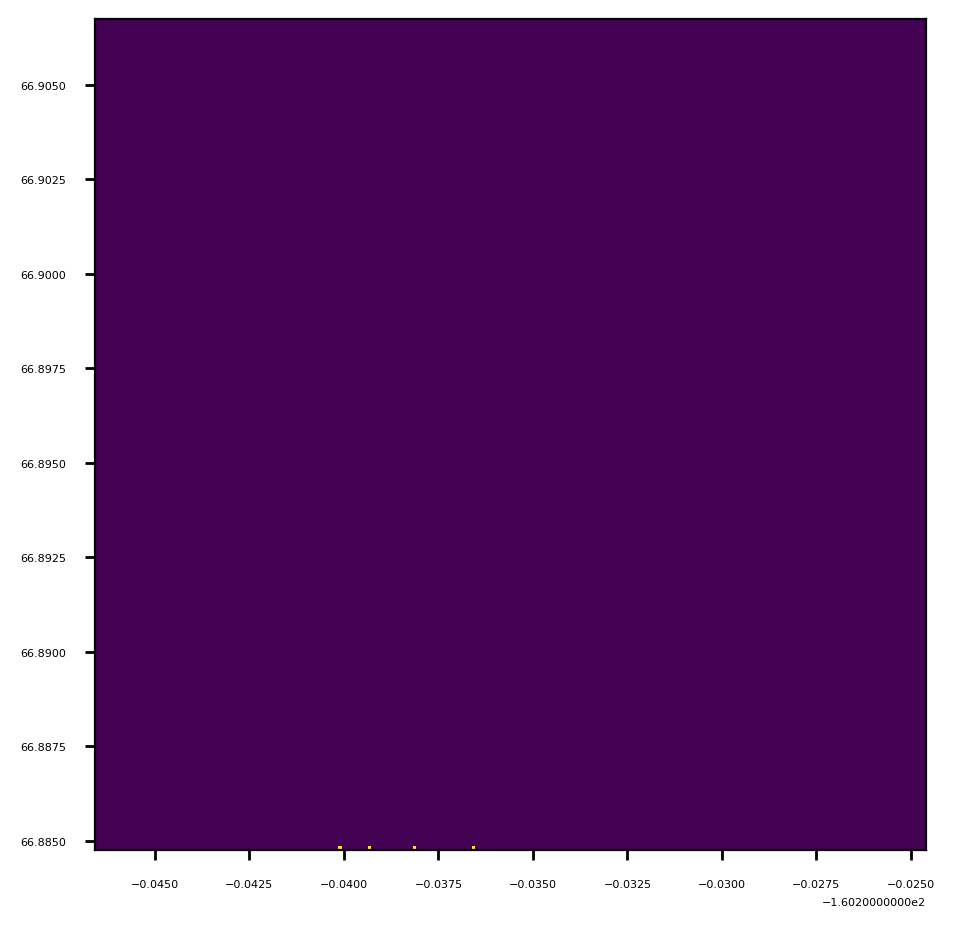

<AxesSubplot:>

In [16]:
# Plot the first band (number of IWP per pixel)
band = 1
print(ex_tile_rio.descriptions[band - 1])
show((ex_tile_rio, band))

prop_pixel_covered_by_IWP


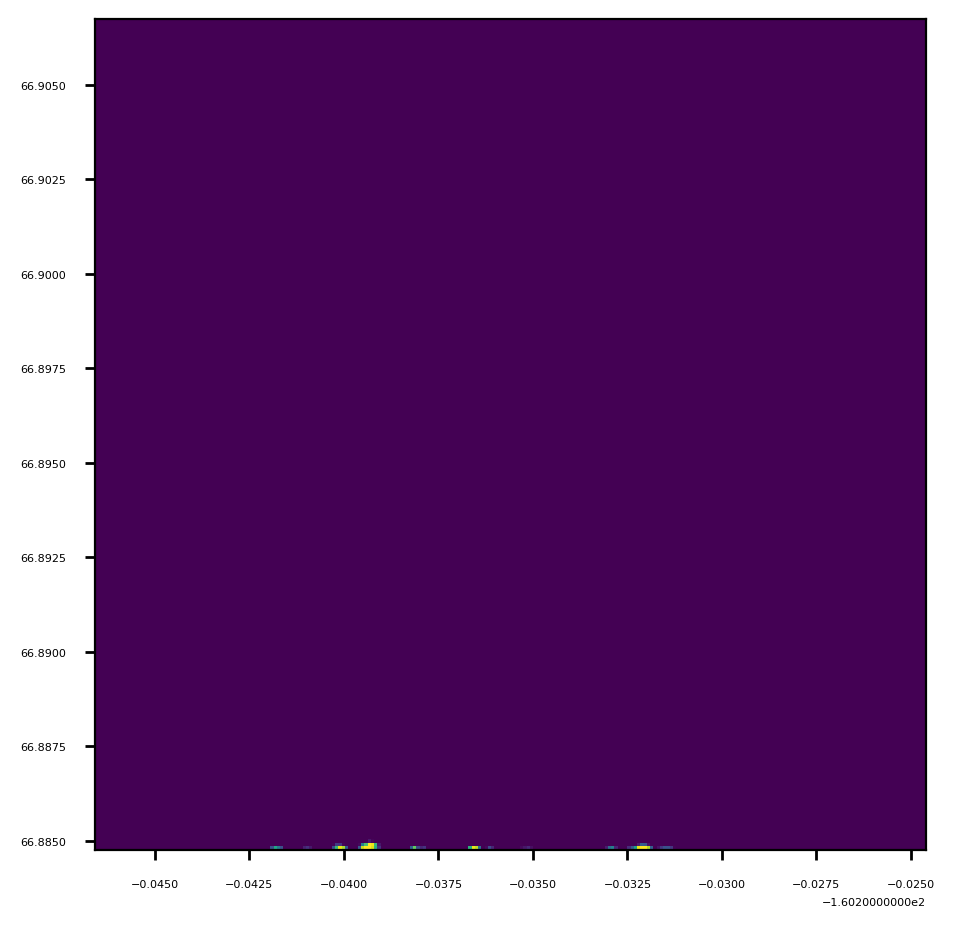

<AxesSubplot:>

In [17]:
# Plot the second band (proportion of pixel covered by IWP)
band = 2
print(ex_tile_rio.descriptions[band - 1])
show((ex_tile_rio, band))